In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from tensorflow import keras
import string
import matplotlib
import matplotlib.pyplot as plt

def get_mnist_dataset():
    test_data_path = os.path.join("./datasets",
        "sign-language-mnist", 
        "sign_mnist_test","")
    train_data_path = os.path.join("./datasets", 
        "sign-language-mnist", 
        "sign_mnist_train","")

    test_pd = pd.read_csv(test_data_path + "sign_mnist_test.csv", 
        skiprows=1)
    train_pd = pd.read_csv(train_data_path + "sign_mnist_train.csv", 
        skiprows=1)
    
    return train_pd, test_pd

train_pd, test_pd = get_mnist_dataset()
train_images, test_images = train_pd.values[:,1:], test_pd.values[:,1:]
train_labels, test_labels = train_pd.values[:,0], test_pd.values[:,0]

class_names = list(string.ascii_lowercase)

In [36]:
from time import time
from sklearn.metrics import classification_report, f1_score

def SearchReport(model):     
    def GetBestModelCTOR(model, best_params):
        def GetParams(best_params):
            ret_str=""          
            for key in sorted(best_params):
                value = best_params[key]
                temp_str = "'" if str(type(value))=="<class 'str'>" else ""
                if len(ret_str)>0:
                    ret_str += ','
                ret_str += f'{key}={temp_str}{value}{temp_str}'  
            return ret_str          
        try:
            param_str = GetParams(best_params)
            return type(model).__name__ + '(' + param_str + ')' 
        except:
            return "N/A(1)"
        
    print("\nBest model set found on train set:")
    print()
    print(f"\tbest parameters={model.best_params_}")
    print(f"\tbest '{model.scoring}' score={model.best_score_}")
    print(f"\tbest index={model.best_index_}")
    print()
    print(f"Best estimator CTOR:")
    print(f"\t{model.best_estimator_}")
    print()
    try:
        print(f"Grid scores ('{model.scoring}') on development set:")
        means = model.cv_results_['mean_test_score']
        stds  = model.cv_results_['std_test_score']
        i=0
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("\t[%2d]: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
            i += 1
    except:
        print("WARNING: the random search do not provide means/stds")
    
    global currmode                
    assert "f1_micro"==str(model.scoring), f"come on, we need to fix the scoring to be able to compare model-fits! Your scoreing={str(model.scoring)}...remember to add scoring='f1_micro' to the search"   
    return f"best: dat={currmode}, score={model.best_score_:0.5f}, model={GetBestModelCTOR(model.estimator,model.best_params_)}", model.best_estimator_ 

def ClassificationReport(model, X_test, y_test, target_names=None):
    assert X_test.shape[0]==y_test.shape[0]
    print("\nDetailed classification report:")
    print("\tThe model is trained on the full development set.")
    print("\tThe scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)                 
    print(classification_report(y_true, y_pred, target_names))
    print()
    
def FullReport(model, X_test, y_test, t):
    print(f"SEARCH TIME: {t:0.2f} sec")
    beststr, bestmodel = SearchReport(model)
    ClassificationReport(model, X_test, y_test)    
    print(f"CTOR for best model: {bestmodel}\n")
    print(f"{beststr}\n")
    return beststr, bestmodel

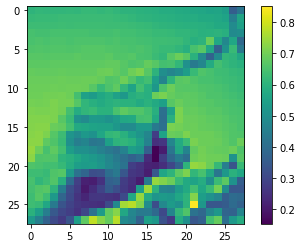

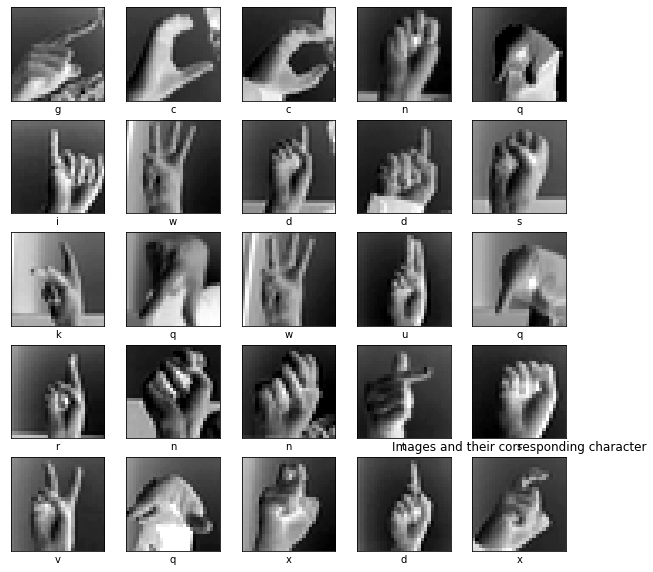

In [4]:
train_images = train_images / 255
test_images = test_images / 255

plt.figure()
plt.imshow(train_images[0].reshape((28, 28)))
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape((28,28)), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.title("Images and their corresponding character")
plt.show()

In [32]:
# Principal Component Analysis (PCA) 
# Reduce dimensions to contain 95% of variance and discard the rest 

from sklearn.decomposition import PCA 

pca = PCA(n_components=0.95) 
train_reduced = pca.fit_transform(train_pd)
test_reduced = pca.fit_transform(test_pd) 

print(train_pd.shape)
print(test_pd.shape)
print()
print(train_reduced.shape)
print(test_reduced.shape)
# Remember to decompress when showing the picture. 
# Some data will be lost
# train_recovered = pca.inverse_transform(train_reduced)
# test_recovered = pca.inverse_transform(test_reduced)

(27454, 785)
(7171, 785)

(27454, 113)
(7171, 83)


In [18]:
# Linear Regression Model
import numpy as np 
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)

model.fit(train_reduced, train_labels)
model.score(train_reduced, train_labels)


0.41273410073717054

In [37]:
# Logistic Regression Model 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

model = LogisticRegression() 
# Needed for SAG & SAGA algoritm 
model_pipe = Pipeline([
    ("std_scaler", StandardScaler()),
    ("regul_reg", model)
])

tuning_parameters = {
    'penalty':('l2', 'none'),
    'solver':('newton-cg', 'saga') # Saga is faster for large datasets
}

CV=5
VERBOSE=0

start = time()
grid_tuned = GridSearchCV(model, tuning_parameters, cv=CV, scoring='f1_micro', verbose=VERBOSE, n_jobs=-1, iid=True)
grid_tuned.fit(train_reduced, train_labels)
t = time()-start

b0, m0= FullReport(grid_tuned , test_reduced, test_labels, t)
print('OK(grid-search)')

KeyboardInterrupt: 